#Respiratory Illness vs Air Quality

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

##Air Quality

###Data Loading and Processing

In [182]:
#Load data set [Air quality]
city_air=pd.read_csv('/content/city_day.csv')

#Checking for missing values
city_air.isnull().sum()

#Converting to date
city_air['date'] = pd.to_datetime(city_air['Datetime'])

#Extracting year and month
city_air['year']=city_air['date'].dt.year
city_air['month']=city_air['date'].dt.month


#Cleaning columns
city_air.columns=[col.strip().lower() for col in city_air.columns]

# Extracting Delhi
delhi_air = city_air[city_air['city'] == 'Delhi'].drop('datetime', axis=1)

# Replace numeric month values with month names (e.g., 1 → January)
delhi_air['month'] = delhi_air['month'].apply(lambda x: calendar.month_name[x])

# Group by year and month, then compute mean for all numerical columns
monthly_summary = delhi_air.groupby(['year', 'month']).mean(numeric_only=True).reset_index()

# View the result
monthly_summary



,year,month,pm2.5,pm10,no,no2,nox,nh3,co,so2,o3,benzene,toluene,xylene,aqi
0,2015,April,280.013333,320.423333,83.443333,67.070000,138.106667,24.976667,5.613667,50.900000,85.076667,9.182333,14.896667,5.337333,229.843333
1,2015,August,259.570968,288.716129,93.003226,77.290323,101.867742,33.116129,4.645161,48.093548,84.896774,8.604194,16.573226,4.940968,234.674194
2,2015,December,273.858065,252.138710,107.809677,68.529032,112.874194,21.683871,6.014516,45.877419,109.825806,10.026452,14.641613,4.680968,292.867742
3,2015,February,223.210714,319.810714,105.396429,73.475000,123.707143,27.939286,3.830714,45.325000,92.046429,10.059286,16.776786,5.215714,261.025000
4,2015,January,247.419355,341.722581,124.306452,81.167742,117.090323,25.770968,4.256774,53.703226,93.500000,9.475484,15.770323,5.940323,265.296774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024,March,253.219355,226.306452,103.822581,80.390323,121.138710,27.025806,5.161613,41.574194,79.948387,9.092581,16.441613,4.396129,268.483871
116,2024,May,246.383871,315.487097,81.919355,72.209677,113.261290,24.222581,5.494516,47.438710,102.829032,9.727097,16.286129,4.387419,252.693548
117,2024,November,189.576667,313.423333,102.960000,80.763333,140.710000,29.400000,4.814000,48.480000,116.400000,10.406000,17.050000,4.976667,269.093333
118,2024,October,289.512903,333.100000,87.796774,60.167742,136.945161,24.025806,4.821290,48.235484,101.712903,10.275161,14.906452,4.631613,195.545161


##Health Data

###Data Loading and Processing

In [180]:
import pandas as pd

# All years to process
all_years = list(range(2015, 2020))

# Define parameters for 2015–16 and 2017–19 separately
params_2015_16 = [
    'Number of cases of Adolescent or Adult deaths (age 6 years & above) with the probable cause being Respiratory diseases including infections',
    'Number of cases of Adolescent or Adult deaths (age 6 years & above) with the probable cause being Tuberculosis'
]

params_2017_19 = {
    'respiratory_deaths': 'Number of Adolscent / Adult deaths due to Respiratory diseases including infections (other than TB)',
    'tb_deaths': 'Number of Adolscent / Adult deaths due to Tuberculosis'
}

# Month order and mapping for fiscal year
month_order = ['april', 'may', 'june', 'july', 'august', 'september',
               'october', 'november', 'december', 'january', 'february', 'march']

fiscal_year_map = {
    'april': lambda y: y, 'may': lambda y: y, 'june': lambda y: y, 'july': lambda y: y,
    'august': lambda y: y, 'september': lambda y: y, 'october': lambda y: y, 'november': lambda y: y,
    'december': lambda y: y, 'january': lambda y: y + 1, 'february': lambda y: y + 1, 'march': lambda y: y + 1
}

# Collect final results
all_data = []

for year in all_years:
    try:
        file = f'/content/filtered_{year}.csv'
        df = pd.read_csv(file)
        df.columns = [col.strip().lower() for col in df.columns]
        df.fillna(0, inplace=True)

        # Processing for 2015 & 2016
        if year in [2015, 2016]:
            df = df.drop(columns=[col for col in ['ï»¿district', 's.no.', 'total'] if col in df.columns], errors='ignore')
            grouped = df.groupby(['parameters', 'type']).sum(numeric_only=True)
            selected = grouped.loc[[(param, '4. Total') for param in params_2015_16]]
            transposed = selected.T
            transposed.columns = ['respiratory_deaths', 'tb_deaths']
            transposed = transposed.reset_index().rename(columns={'index': 'month'})
            transposed['month'] = transposed['month'].str.lower()
            transposed['year'] = transposed['month'].map(lambda m: fiscal_year_map[m](year))
            all_data.append(transposed[['year', 'month', 'respiratory_deaths', 'tb_deaths']])

        # Processing for 2017–2019
        else:
            df = df.groupby('parameters').sum(numeric_only=True)
            columns_to_keep = [col for col in df.columns if 'total' in col and any(month in col for month in month_order)]
            df = df[columns_to_keep]
            rename_map = {col: month for col in df.columns for month in month_order if month in col}
            df.rename(columns=rename_map, inplace=True)
            df = df.loc[df.index.isin(params_2017_19.values())]
            df_t = df.T.reset_index().rename(columns={'index': 'month'})
            df_t.rename(columns={v: k for k, v in params_2017_19.items()}, inplace=True)
            df_t['year'] = df_t['month'].map(lambda m: fiscal_year_map[m](year))
            final_df = df_t[['year', 'month', 'respiratory_deaths', 'tb_deaths']]
            all_data.append(final_df)

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Combine all data into one DataFrame
combined_df = pd.concat(all_data, ignore_index=True)

# Sort by year and month
combined_df = combined_df.sort_values(by=['year', 'month'], key=lambda col: pd.Categorical(col, categories=month_order, ordered=True) if col.name == 'month' else col)

# Show result
combined_df

,year,month,respiratory_deaths,tb_deaths
0,2015,april,142.0,64.0
1,2015,may,166.0,80.0
2,2015,june,194.0,58.0
3,2015,july,122.0,57.0
4,2015,august,165.0,71.0
5,2015,september,225.0,45.0
6,2015,october,150.0,57.0
7,2015,november,180.0,62.0
8,2015,december,221.0,38.0
12,2016,april,170.0,72.0


##Merging Datasets

In [216]:
# Fix month format in AQI dataset
monthly_summary['month'] = monthly_summary['month'].str.lower()

# Merge with health dataset
merged_df = pd.merge(monthly_summary, combined_df, on=['year', 'month'], how='inner')

import calendar

# Create a dictionary mapping lowercase month names to numbers
month_to_num = {month.lower(): idx for idx, month in enumerate(calendar.month_name) if month}

# Apply mapping
merged_df['month_num'] = merged_df['month'].map(month_to_num)

# View the updated dataframe
merged_df



,year,month,pm2.5,pm10,no,no2,nox,nh3,co,so2,o3,benzene,toluene,xylene,aqi,respiratory_deaths,tb_deaths,month_num
0,2015,april,280.013333,320.423333,83.443333,67.070000,138.106667,24.976667,5.613667,50.900000,85.076667,9.182333,14.896667,5.337333,229.843333,142.0,64.0,4
1,2015,august,259.570968,288.716129,93.003226,77.290323,101.867742,33.116129,4.645161,48.093548,84.896774,8.604194,16.573226,4.940968,234.674194,165.0,71.0,8
2,2015,december,273.858065,252.138710,107.809677,68.529032,112.874194,21.683871,6.014516,45.877419,109.825806,10.026452,14.641613,4.680968,292.867742,221.0,38.0,12
3,2015,july,278.858065,240.725806,101.374194,70.958065,124.100000,28.012903,4.787097,55.754839,106.945161,10.946774,16.440968,5.676774,235.270968,122.0,57.0,7
4,2015,june,248.936667,253.800000,103.743333,79.756667,128.430000,27.050000,5.373000,38.606667,105.906667,8.508333,13.934000,6.202333,238.636667,194.0,58.0,6
5,2015,may,208.754839,311.245161,92.029032,80.596774,119.451613,23.277419,5.560645,33.396774,111.774194,10.467419,14.453548,4.323548,260.670968,166.0,80.0,5
6,2015,november,251.950000,282.290000,106.176667,75.216667,128.500000,21.673333,5.070667,53.596667,94.956667,9.379667,17.142333,4.982667,258.943333,180.0,62.0,11
7,2015,october,232.109677,331.303226,95.012903,79.783871,117.312903,26.764516,4.024839,52.403226,101.754839,10.189677,16.347742,6.003226,213.267742,150.0,57.0,10
8,2015,september,224.026667,260.973333,97.533333,65.700000,134.020000,28.073333,5.243000,57.466667,93.770000,9.181000,18.767667,4.743000,238.563333,225.0,45.0,9
9,2016,april,276.230000,322.150000,92.763333,72.080000,150.826667,30.330000,4.958333,53.516667,112.253333,9.052667,13.295000,4.716667,234.356667,170.0,72.0,4


##Exploratory Data Analysis

###Summary Statistics

In [203]:
# Quick stats for pollutants and deaths
merged_df[['pm2.5', 'pm10', 'no', 'no2', 'nox', 'nh3', 'co', 'so2', 'o3', 'benzene', 'toluene', 'xylene', 'aqi',
           'respiratory_deaths', 'tb_deaths']].describe().T

,count,mean,std,min,25%,50%,75%,max
pm2.5,60.0,252.009749,26.919737,189.435484,232.071774,251.792857,274.036290,307.483871
pm10,60.0,300.332927,31.414125,216.183871,278.364747,304.082903,324.512903,364.443333
no,60.0,99.400026,9.456252,79.843333,92.750726,97.985484,104.508871,122.916667
no2,60.0,76.673981,7.261714,57.848387,71.932258,76.700056,81.055833,91.914286
nox,60.0,123.482608,14.090494,92.858065,115.612223,124.756667,131.793898,157.814286
nh3,60.0,25.171994,3.000520,19.545161,22.807647,25.043172,27.191237,33.116129
co,60.0,5.023400,0.448904,4.014516,4.684065,5.024833,5.344976,6.140645
so2,60.0,49.350241,5.325812,33.396774,45.944355,49.854839,53.281452,58.435484
o3,60.0,100.090842,8.179199,80.922581,94.473145,101.088548,106.352500,118.770968
benzene,60.0,9.914632,0.959650,7.412000,9.152605,10.059151,10.565726,11.957500


###Correlation Matrix

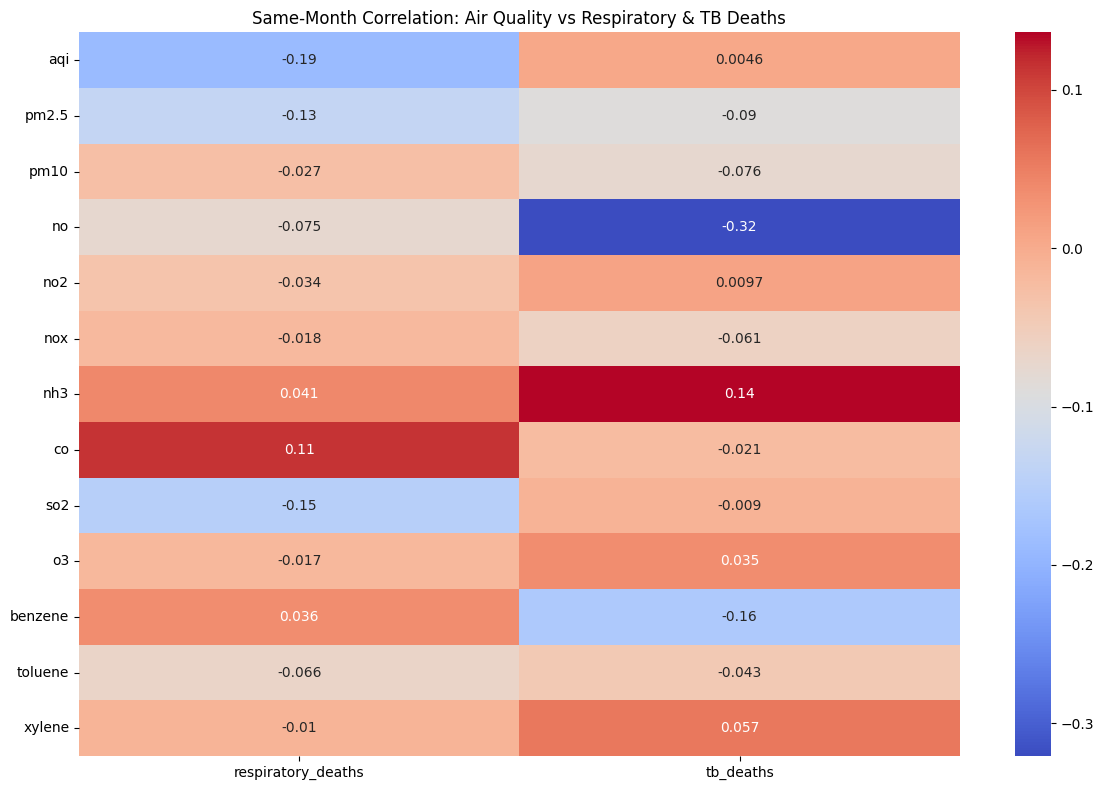

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

# List all air quality variables (non-lagged)
pollutants = ['aqi', 'pm2.5', 'pm10', 'no', 'no2', 'nox', 'nh3', 'co', 'so2', 'o3', 'benzene', 'toluene', 'xylene']

# Subset merged_df for same-month correlation
same_month_df = merged_df[pollutants + ['respiratory_deaths', 'tb_deaths']]

# Compute correlation matrix
immediate_corr = same_month_df.corr(numeric_only=True)[['respiratory_deaths', 'tb_deaths']]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(immediate_corr.drop(['respiratory_deaths', 'tb_deaths']),
            annot=True, cmap='coolwarm')
plt.title('Same-Month Correlation: Air Quality vs Respiratory & TB Deaths')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

###Lag analysis

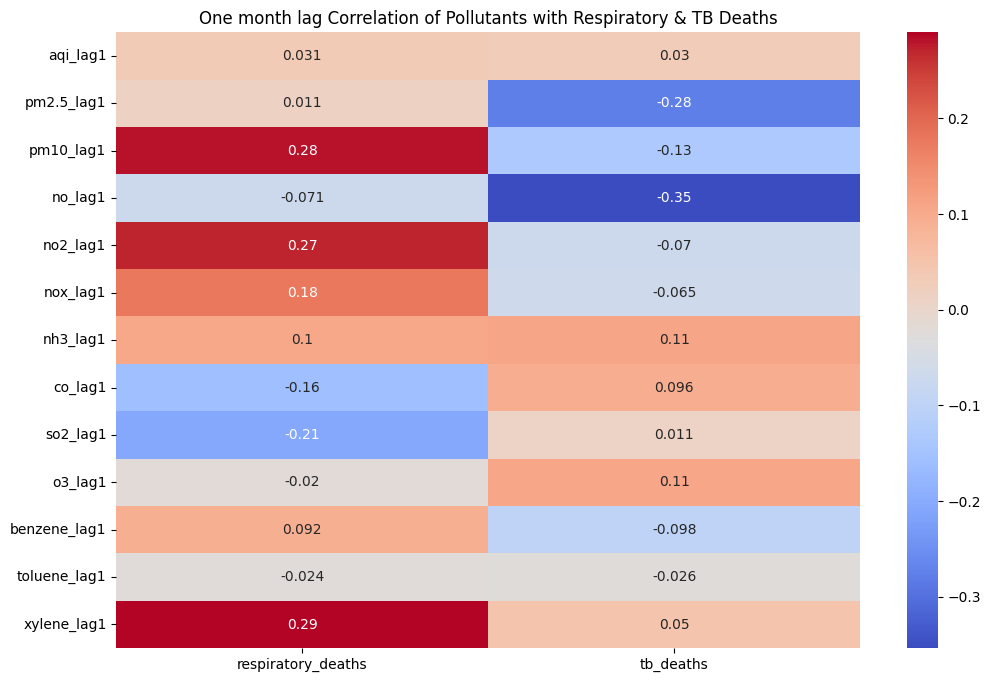

In [212]:
# Create lagged variables (1-month lag)
pollutants = ['aqi', 'pm2.5', 'pm10', 'no', 'no2', 'nox', 'nh3', 'co', 'so2', 'o3', 'benzene', 'toluene', 'xylene']

for col in pollutants:
    merged_df[f'{col}_lag1'] = merged_df[col].shift(1)

# Get only lagged columns and deaths
lagged_cols = [f'{col}_lag1' for col in pollutants]
lagged_df = merged_df[lagged_cols + ['respiratory_deaths', 'tb_deaths']]

# Correlation matrix
lag_corr = lagged_df.corr(numeric_only=True)[['respiratory_deaths', 'tb_deaths']]

#Plot
plt.figure(figsize=(12, 8))
sns.heatmap(lag_corr.drop(['respiratory_deaths', 'tb_deaths'], axis=0), annot=True, cmap='coolwarm')
plt.title("One month lag Correlation of Pollutants with Respiratory & TB Deaths")
plt.show()

###Deaths Over Time

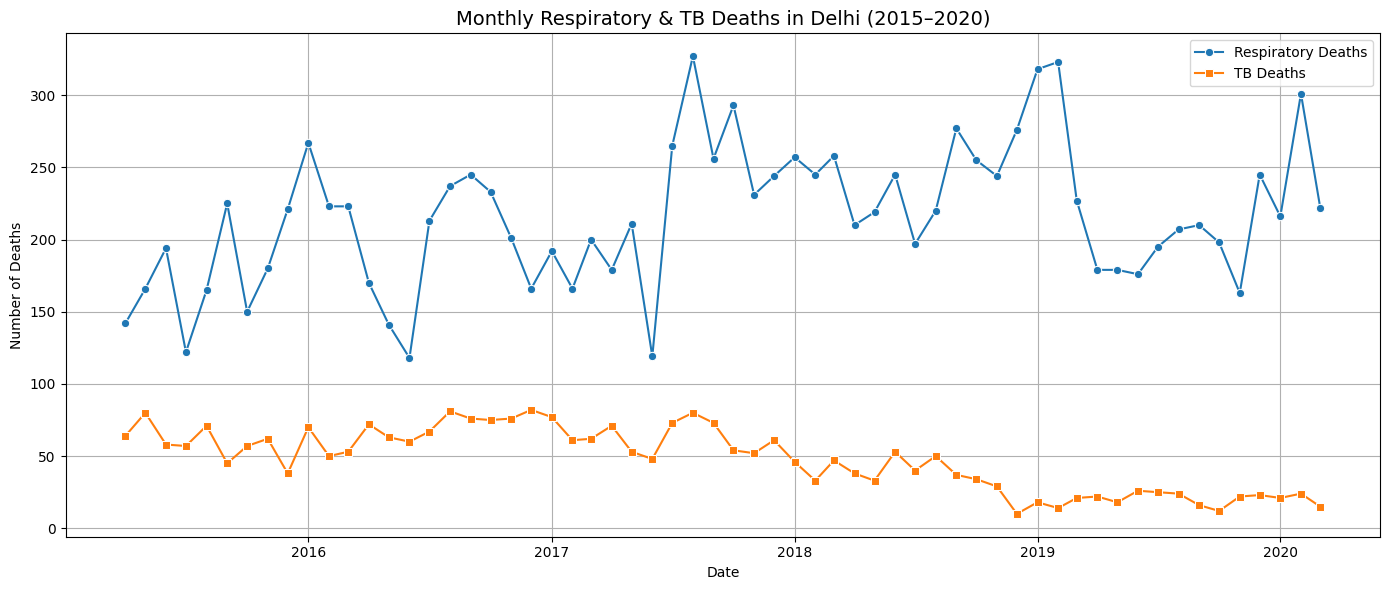

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' column exists for proper time axis
merged_df['date'] = pd.to_datetime(dict(year=merged_df['year'], month=merged_df['month_num'], day=1))

# Set figure size and style
plt.figure(figsize=(14, 6))
sns.lineplot(data=merged_df, x='date', y='respiratory_deaths', label='Respiratory Deaths', marker='o')
sns.lineplot(data=merged_df, x='date', y='tb_deaths', label='TB Deaths', marker='s')

# Aesthetics
plt.title('Monthly Respiratory & TB Deaths in Delhi (2015–2020)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()